In [55]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms
import cv2

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from sklearn.metrics import classification_report

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
# create a dataset and dataloader for the data
data_dir_train = pathlib.Path('../data/SkinCancer/train')
data_dir_test = pathlib.Path('../data/SkinCancer/test')
data_dir_val = pathlib.Path('../data/SkinCancer/val')

In [4]:
# DataLoader for training data
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        data_dir_train,
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    ),
    batch_size=128,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        data_dir_test,
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    ),
    batch_size=128,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        data_dir_val,
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    ),
    batch_size=1,
    shuffle=True 
)

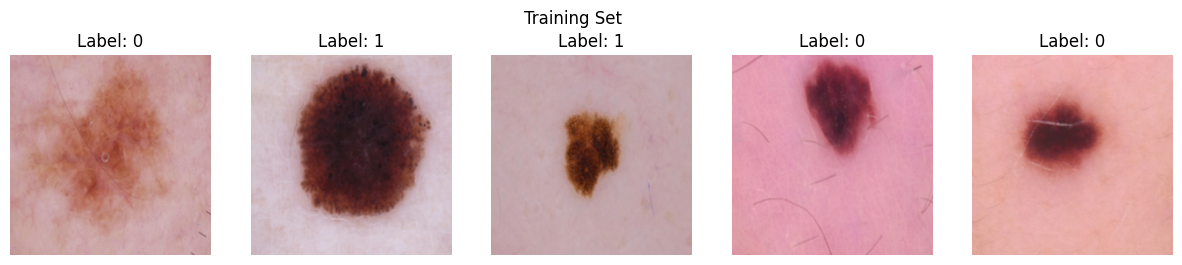

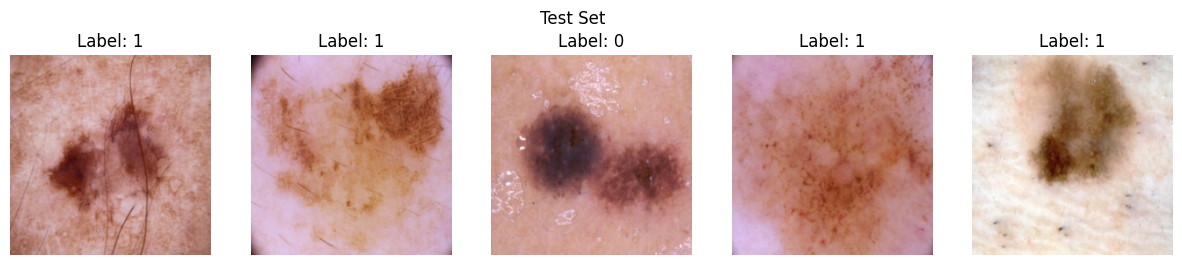

In [5]:
# plot the first 5 images in the training set, the first 5 images in the test set
def plot_images(loader, title):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i, (image, label) in enumerate(loader):
        if i == 5:
            break
        axs[i].imshow(image[i].permute(1, 2, 0))
        axs[i].set_title(f"Label: {label[i].item()}")
        axs[i].axis("off")
    fig.suptitle(title)
    plt.show()

plot_images(train_loader, "Training Set")
plot_images(test_loader, "Test Set")

In [6]:
# create a custom convolutional neural network model for the classification task

class CustomCNN(torch.nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu1 = torch.nn.LeakyReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = torch.nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.relu2 = torch.nn.LeakyReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = torch.nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.relu3 = torch.nn.LeakyReLU()
        self.conv4 = torch.nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.relu4 = torch.nn.LeakyReLU()
        self.conv5 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu5 = torch.nn.LeakyReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(256 * 6 * 6, 4096)
        self.relu6 = torch.nn.LeakyReLU()
        #self.dropout1 = torch.nn.Dropout()
        self.fc2 = torch.nn.Linear(4096, 4096)
        self.relu7 = torch.nn.LeakyReLU()
        #self.dropout2 = torch.nn.Dropout()
        self.fc3 = torch.nn.Linear(4096, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.pool3(self.relu5(self.conv5(x)))
        x = self.flatten(x)
        x = self.relu6(self.fc1(x))#self.dropout1()
        x = self.relu7(self.fc2(x))#self.dropout2()
        x = self.fc3(x)
        x = self.sigmoid(x)
        x = x.view(-1)
        return x
    
# create model
model = CustomCNN().to(device)

In [7]:
# test model with a random input
x = torch.randn(1, 3, 224, 224).to(device)
y = model(x)
print(y)

tensor([0.5026], device='cuda:0', grad_fn=<ViewBackward0>)


In [8]:
# test model with the first batch of the training data
for i, (image, label) in enumerate(train_loader):
    if i == 1:
        break
    image = image.to(device)
    label = label.to(device)
    output = model(image)
    print(output)
    print(label)

tensor([0.5021, 0.5022, 0.5022, 0.5021, 0.5022, 0.5021, 0.5022, 0.5022, 0.5021,
        0.5022, 0.5021, 0.5021, 0.5021, 0.5021, 0.5021, 0.5022, 0.5022, 0.5021,
        0.5022, 0.5021, 0.5021, 0.5022, 0.5021, 0.5021, 0.5021, 0.5021, 0.5021,
        0.5022, 0.5022, 0.5022, 0.5022, 0.5021, 0.5021, 0.5022, 0.5022, 0.5021,
        0.5021, 0.5022, 0.5021, 0.5021, 0.5021, 0.5021, 0.5021, 0.5022, 0.5021,
        0.5022, 0.5021, 0.5022, 0.5021, 0.5022, 0.5022, 0.5022, 0.5022, 0.5022,
        0.5021, 0.5021, 0.5022, 0.5022, 0.5021, 0.5021, 0.5022, 0.5021, 0.5022,
        0.5021, 0.5022, 0.5021, 0.5021, 0.5021, 0.5022, 0.5021, 0.5021, 0.5022,
        0.5022, 0.5021, 0.5021, 0.5021, 0.5021, 0.5021, 0.5021, 0.5022, 0.5021,
        0.5021, 0.5021, 0.5021, 0.5021, 0.5022, 0.5022, 0.5021, 0.5021, 0.5022,
        0.5021, 0.5021, 0.5021, 0.5022, 0.5021, 0.5022, 0.5021, 0.5022, 0.5021,
        0.5021, 0.5021, 0.5021, 0.5022, 0.5022, 0.5022, 0.5021, 0.5021, 0.5021,
        0.5022, 0.5021, 0.5021, 0.5021, 

In [9]:
#criterion = torch.nn.BCELoss()
criterion = torch.nn.L1Loss() # In this particular case, we are using L1 loss instead of BCE loss: accuracy + 10% with L1 loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

# train the model
model.train()
for epoch in range(100):
    epoch_loss = 0
    epoch_accuracy = 0
    num_batches = len(train_loader)
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        predictions = (outputs > 0.5).float()

        loss.backward()
        optimizer.step()
        
        accuracy = (predictions == labels).float().mean()
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss/num_batches}, Accuracy: {epoch_accuracy/num_batches}")

Epoch 1, Loss: 0.5000320743946802, Accuracy: 0.4814567878132775
Epoch 2, Loss: 0.49966679442496525, Accuracy: 0.546556123665401
Epoch 3, Loss: 0.49928365576834904, Accuracy: 0.5445848788533892
Epoch 4, Loss: 0.49870637626875014, Accuracy: 0.546802526428586
Epoch 5, Loss: 0.498057192280179, Accuracy: 0.546556123665401
Epoch 6, Loss: 0.49718165965307326, Accuracy: 0.546802526428586
Epoch 7, Loss: 0.495958278576533, Accuracy: 0.5458169068608966
Epoch 8, Loss: 0.4936192645913079, Accuracy: 0.5475417432330903
Epoch 9, Loss: 0.4903091944399334, Accuracy: 0.5470489320300874
Epoch 10, Loss: 0.48563379758880254, Accuracy: 0.546063312462398
Epoch 11, Loss: 0.47816537959235056, Accuracy: 0.5463097180638995
Epoch 12, Loss: 0.4703011668863751, Accuracy: 0.5463097180638995
Epoch 13, Loss: 0.462233970562617, Accuracy: 0.546802526428586
Epoch 14, Loss: 0.45734971903619315, Accuracy: 0.5470489320300874
Epoch 15, Loss: 0.45518204995564054, Accuracy: 0.5463097180638995
Epoch 16, Loss: 0.4534572320325034,

In [10]:
# evaluate the model
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float()

In [11]:
# evaluate the model
print("Classification Report")
print(classification_report(labels.cpu().numpy(), predicted.cpu().numpy()))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        30
           1       0.81      0.96      0.88        23

    accuracy                           0.89        53
   macro avg       0.89      0.89      0.89        53
weighted avg       0.90      0.89      0.89        53



In [13]:
# save the model
torch.save(model.state_dict(), "customCNN_1.pth")

---

In [46]:
# take the first 10 images from the validation set
images = []
labels = []
for i in range(10):
    image, label = next(iter(val_loader))
    images.append(image)
    labels.append(label)

In [47]:
images[0].shape

torch.Size([1, 3, 224, 224])

In [48]:
labels[0]

tensor([0])

In [49]:
# remove the model from the GPU
model = model.cpu()
# clean GPU cache
torch.cuda.empty_cache()

In [50]:
interpretabilities_dict = {}
interpretabilities_dict['ig'] = []
interpretabilities_dict['saliency'] = []
interpretabilities_dict['deep_lift'] = []

In [51]:
model.eval()
for i in range(10):
    image = images[i]
    label = labels[i]
    # Integrated Gradients
    ig = IntegratedGradients(model)
    attr_ig, delta_ig = ig.attribute(image, target=None, return_convergence_delta=True, n_steps=300)
    attr_ig = attr_ig.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    attr_ig = np.transpose(attr_ig, (1, 0, 2))
    attr_ig_sum_norm = np.sum(np.abs(attr_ig), axis=2)
    attr_ig_sum_norm = attr_ig_sum_norm / np.max(attr_ig_sum_norm)
    interpretabilities_dict['ig'].append(attr_ig_sum_norm)
    # Saliency
    saliency = Saliency(model)
    attr_saliency = saliency.attribute(image, target=None)
    attr_saliency = attr_saliency.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    attr_saliency = np.transpose(attr_saliency, (1, 0, 2))
    attr_saliency_sum_norm = np.sum(np.abs(attr_saliency), axis=2)
    attr_saliency_sum_norm = attr_saliency_sum_norm / np.max(attr_saliency_sum_norm)
    interpretabilities_dict['saliency'].append(attr_saliency_sum_norm)
    # DeepLift
    dl = DeepLift(model)
    attr_dl = dl.attribute(image, target=None)
    attr_dl = attr_dl.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    attr_dl = np.transpose(attr_dl, (1, 0, 2))
    attr_dl_sum_norm = np.sum(np.abs(attr_dl), axis=2)
    attr_dl_sum_norm = attr_dl_sum_norm / np.max(attr_dl_sum_norm)
    interpretabilities_dict['deep_lift'].append(attr_dl_sum_norm)

/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/davide/Desktop/SAM_tests/SAM_tests/env/lib/python3.12/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [52]:
interpretabilities_dict['deep_lift'][0].shape

(224, 224)

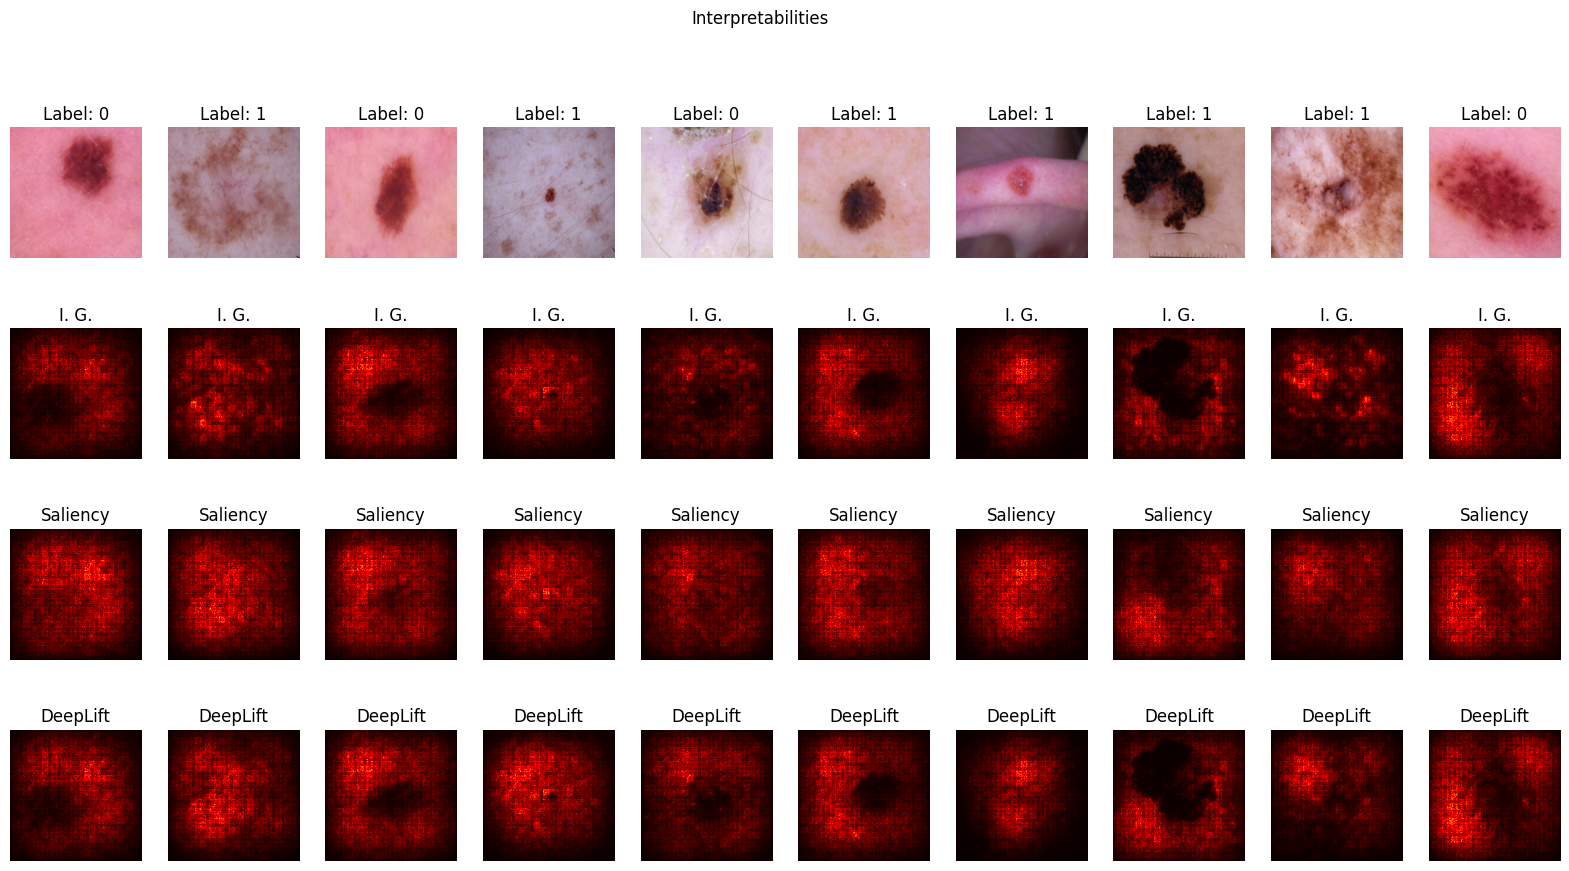

In [53]:
fig, axs = plt.subplots(4, 10, figsize=(20, 10))
for i in range(10):
    axs[0,i].imshow(images[i].squeeze().permute(1, 2, 0))
    axs[0,i].set_title(f"Label: {labels[i].item()}")
    axs[0,i].axis("off")
    axs[1,i].imshow(interpretabilities_dict['ig'][i], cmap="hot")
    axs[1,i].set_title("I. G.")
    axs[1,i].axis("off")
    axs[2,i].imshow(interpretabilities_dict['saliency'][i], cmap="hot")
    axs[2,i].set_title("Saliency")
    axs[2,i].axis("off")
    axs[3,i].imshow(interpretabilities_dict['deep_lift'][i], cmap="hot")
    axs[3,i].set_title("DeepLift")
    axs[3,i].axis("off")
fig.suptitle("Interpretabilities")
plt.show()

---

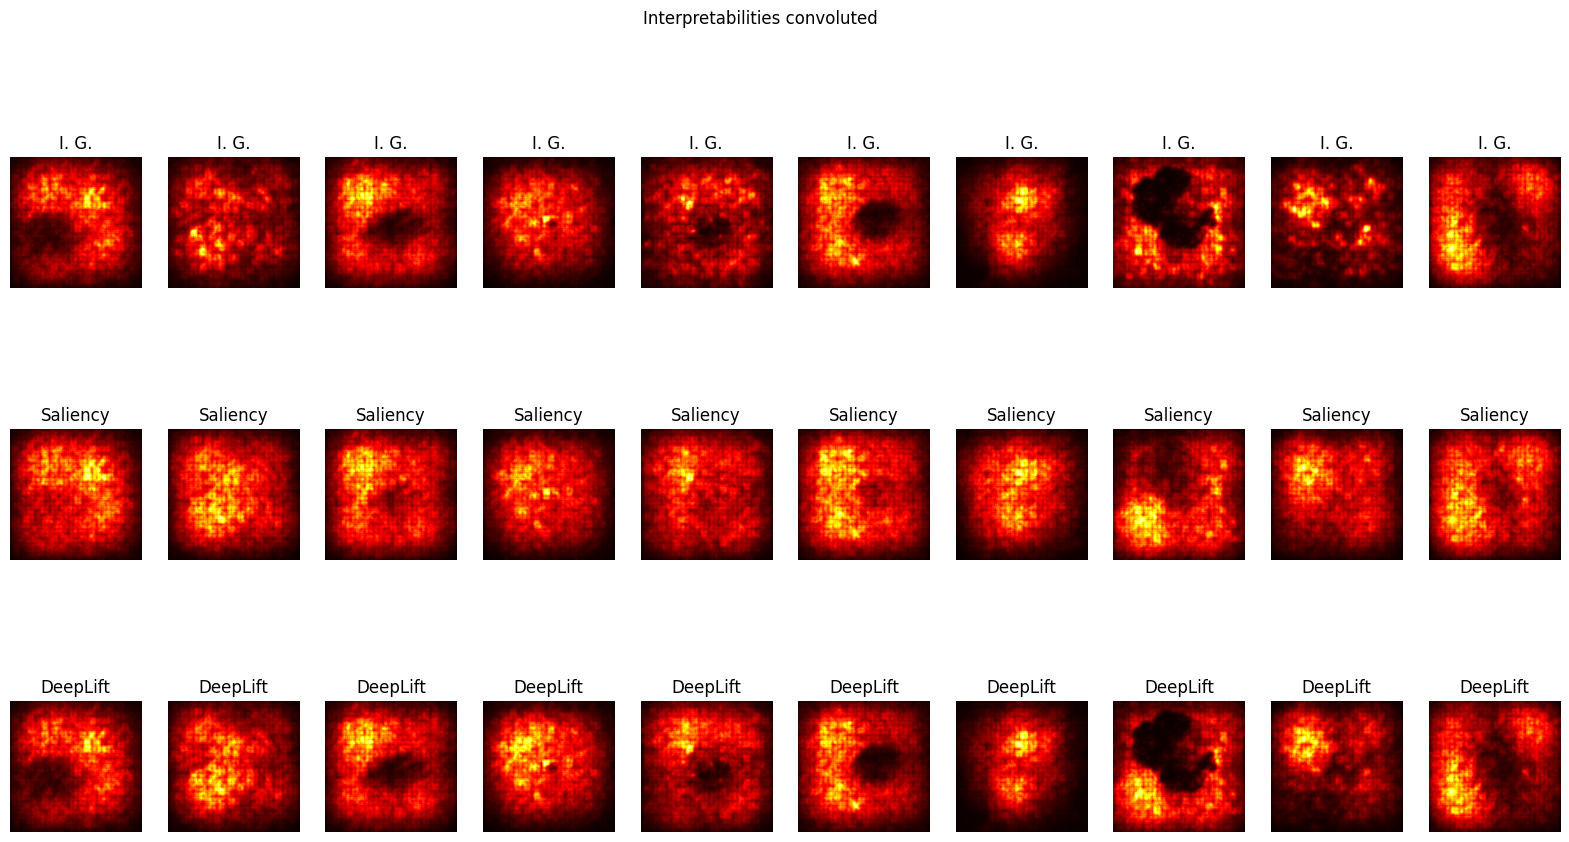

In [ ]:
fig, axs = plt.subplots(3, 10, figsize=(20, 10))
for i in range(10):
    # apply convolution filter with opencv
    kernel = np.ones((5,5),np.float32)/25

    ig = interpretabilities_dict['ig'][i]
    ig_filtered = cv2.filter2D(ig,-1,kernel)
    axs[0,i].imshow(ig_filtered, cmap="hot")
    axs[0,i].set_title("I. G.")
    axs[0,i].axis("off")

    saliency = interpretabilities_dict['saliency'][i]
    saliency_filtered = cv2.filter2D(saliency,-1,kernel)
    axs[1,i].imshow(saliency_filtered, cmap="hot")
    axs[1,i].set_title("Saliency")
    axs[1,i].axis("off")

    deep_lift = interpretabilities_dict['deep_lift'][i]
    deep_lift_filtered = cv2.filter2D(deep_lift,-1,kernel)
    axs[2,i].imshow(deep_lift_filtered, cmap="hot")
    axs[2,i].set_title("DeepLift")
    axs[2,i].axis("off")
fig.suptitle("Interpretabilities convoluted")
plt.show()

In [123]:
engineered_prompt_coordinates_dict = {}
engineered_prompt_coordinates_dict['ig'] = []
engineered_prompt_coordinates_dict['saliency'] = []
engineered_prompt_coordinates_dict['deep_lift'] = []

In [124]:
# take x and y coordinates for the top 10 less "important" pixel and use it as foreground (focus the item as background, best simple strategy) for the prompt
for i in range(10):
    attr_ig_sum = interpretabilities_dict['ig'][i]
    x, y = np.unravel_index(np.argsort(attr_ig_sum, axis=None), attr_ig_sum.shape)
    x = x[:10]
    y = y[:10]
    coordinates = list(zip(x, y))
    engineered_prompt_coordinates_dict['ig'].append(coordinates)

    attr_saliency_sum = interpretabilities_dict['saliency'][i]
    x, y = np.unravel_index(np.argsort(attr_saliency_sum, axis=None), attr_saliency_sum.shape)
    x = x[:10]
    y = y[:10]
    coordinates = list(zip(x, y))
    engineered_prompt_coordinates_dict['saliency'].append(coordinates)

    attr_dl_sum = interpretabilities_dict['deep_lift'][i]
    x, y = np.unravel_index(np.argsort(attr_dl_sum, axis=None), attr_dl_sum.shape)
    x = x[:10]
    y = y[:10]
    coordinates = list(zip(x, y))
    engineered_prompt_coordinates_dict['deep_lift'].append(coordinates)

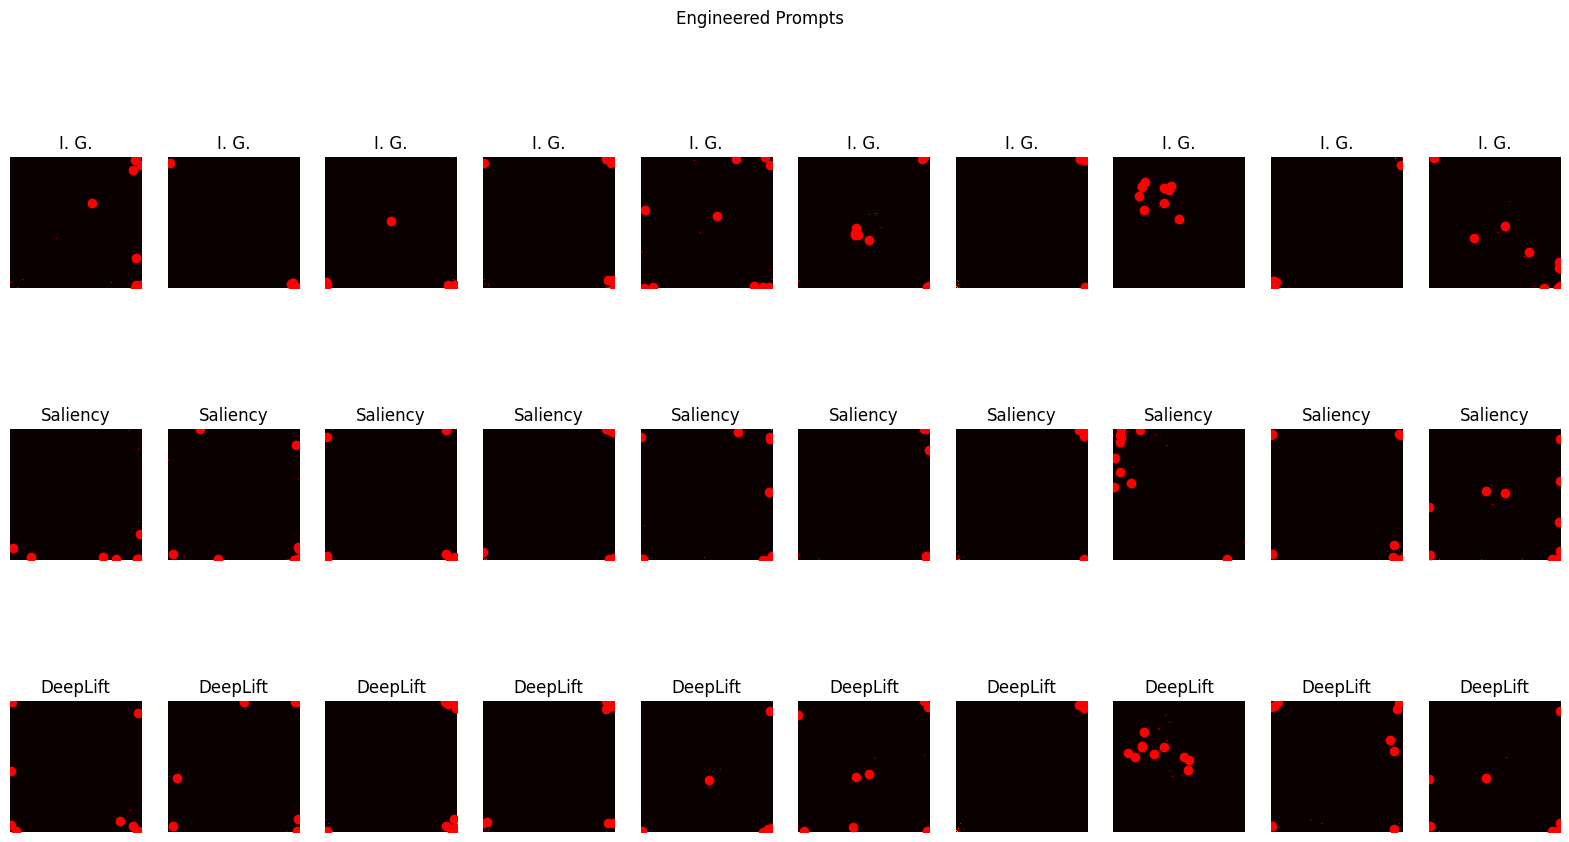

In [125]:
# plot points
fig, axs = plt.subplots(3, 10, figsize=(20, 10))
for i in range(10):
    img = np.zeros((224, 224))
    for x, y in engineered_prompt_coordinates_dict['ig'][i]:
        img[x, y] = 1
    axs[0,i].imshow(img, cmap="hot")
    axs[0,i].scatter(*zip(*engineered_prompt_coordinates_dict['ig'][i]), c="red")
    axs[0,i].set_title("I. G.")
    axs[0,i].axis("off")

    img = np.zeros((224, 224))
    for x, y in engineered_prompt_coordinates_dict['saliency'][i]:
        img[x, y] = 1
    axs[1,i].imshow(img, cmap="hot")
    axs[1,i].scatter(*zip(*engineered_prompt_coordinates_dict['saliency'][i]), c="red")
    axs[1,i].set_title("Saliency")
    axs[1,i].axis("off")

    img = np.zeros((224, 224))
    for x, y in engineered_prompt_coordinates_dict['deep_lift'][i]:
        img[x, y] = 1
    axs[2,i].imshow(img, cmap="hot")
    axs[2,i].scatter(*zip(*engineered_prompt_coordinates_dict['deep_lift'][i]), c="red")
    axs[2,i].set_title("DeepLift")
    axs[2,i].axis("off")
fig.suptitle("Engineered Prompts")
plt.show()

In [126]:
sam2_checkpoint = "../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [127]:
sam2_segmentations_dict = {}
sam2_segmentations_dict['ig'] = []
sam2_segmentations_dict['saliency'] = []
sam2_segmentations_dict['deep_lift'] = []
sam2_segmentations_dict['auto'] = []

In [128]:
for i in range(10):
    image = images[i].squeeze(0)
    label = labels[i]
    predictor.set_image(np.array(image.permute(1, 2, 0)))
    # Integrated Gradients prompt
    prompt_points = engineered_prompt_coordinates_dict['ig'][i]
    prompt_labels = [1] * len(prompt_points) # all foreground
    mask_ig, _, _ = predictor.predict(point_coords=prompt_points, point_labels=prompt_labels, multimask_output=False)

    # Saliency prompt
    prompt_points = engineered_prompt_coordinates_dict['saliency'][i]
    prompt_labels = [1] * len(prompt_points) # all foreground
    mask_saliency, _, _= predictor.predict(point_coords=prompt_points, point_labels=prompt_labels, multimask_output=False)

    # DeepLift prompt
    prompt_points = engineered_prompt_coordinates_dict['deep_lift'][i]
    prompt_labels = [1] * len(prompt_points) # all foreground
    mask_deep_lift, _, _ = predictor.predict(point_coords=prompt_points, point_labels=prompt_labels, multimask_output=False)

    # Auto prompt
    mask_auto, _, _ = predictor.predict(point_coords=None, point_labels=None, multimask_output=False)

    sam2_segmentations_dict['ig'].append(mask_ig)
    sam2_segmentations_dict['saliency'].append(mask_saliency)
    sam2_segmentations_dict['deep_lift'].append(mask_deep_lift)
    sam2_segmentations_dict['auto'].append(mask_auto)

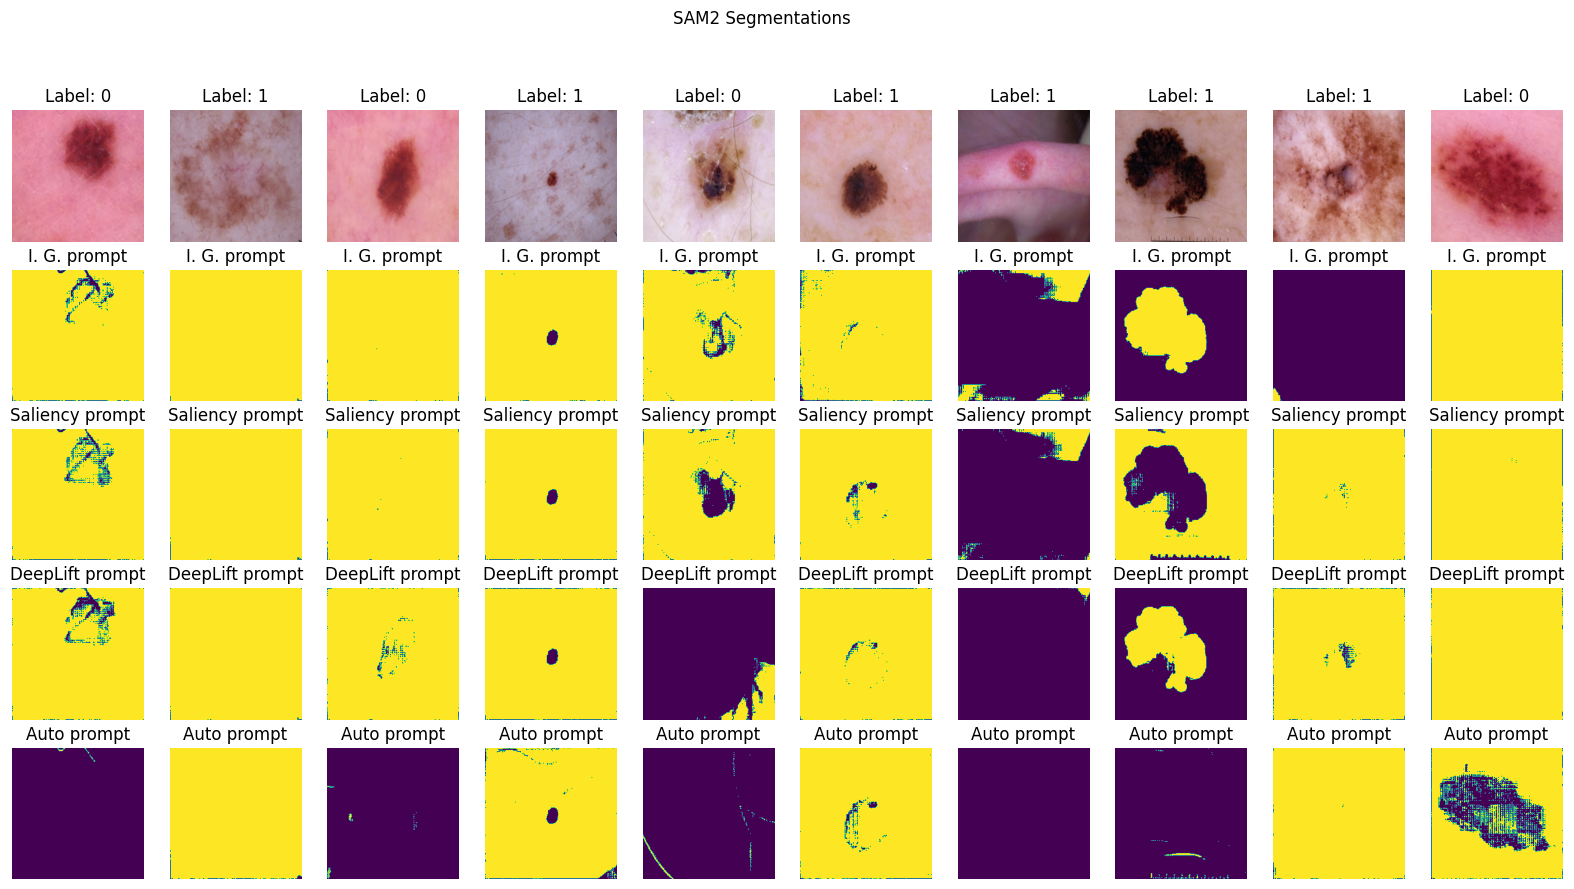

In [129]:
fig, axs = plt.subplots(5, 10, figsize=(20, 10))

for i in range(10):
    axs[0,i].imshow(images[i].squeeze().permute(1, 2, 0))
    axs[0,i].set_title(f"Label: {labels[i].item()}")
    axs[0,i].axis("off")
    axs[1,i].imshow(sam2_segmentations_dict['ig'][i].squeeze())
    axs[1,i].set_title("I. G. prompt")
    axs[1,i].axis("off")
    axs[2,i].imshow(sam2_segmentations_dict['saliency'][i].squeeze())
    axs[2,i].set_title("Saliency prompt")
    axs[2,i].axis("off")
    axs[3,i].imshow(sam2_segmentations_dict['deep_lift'][i].squeeze())
    axs[3,i].set_title("DeepLift prompt")
    axs[3,i].axis("off")
    axs[4,i].imshow(sam2_segmentations_dict['auto'][i].squeeze())
    axs[4,i].set_title("Auto prompt")
    axs[4,i].axis("off")
fig.suptitle("SAM2 Segmentations")
plt.show()